In [1]:
# libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import datetime
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
import chart_studio.plotly as py
import cufflinks as cf
from lifelines import KaplanMeierFitter
cf.go_offline()
from causalnex.evaluation import classification_report

In [2]:
hs1 = pd.read_csv('C:/Users/Data Analyst/Documents/Otros/Proyecto churn/mx-so-batch-1.csv')
hs1.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Profile Completeness - Percentage [Batch],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,HubSpot Team,Country [batch],...,Doctor stats - Visits (booked by user) count [batch],Company ID,Name,Phone Number,City,Company owner,Last Activity Date,Country/Region,Industry,Create Date
0,58015869,Yes,NaN,88.0,Cirujano general,Isabel Francisca,Manco Toro,Miguel Varela Cid,MX_CS_FAR_1,Mexico,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58016381,Yes,yes,91.0,Dentista - Odontólogo,Yazmin,Vivian Carlos,Francisco Flores González,MX_CS_FAR_1,Mexico,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58015871,Yes,yes,100.0,Cirujano pediátrico,Rene,Carmona Barba,Santiago Hernández Estrada,MX_CS_FAR_1,Mexico,...,9.0,2.342261e+09,hip-pospadias.com,55 4203 9589,CDMX,Jaqueline Sarai Lobaco Perez,2020-01-26 20:24,México,NaN,2019-08-20 20:03
3,58016357,Yes,NaN,99.0,Internista,Héctor Eduardo,Dueñas Silva,Jose Eduardo Vargas Bernal,MX_CS_FAR_1,Mexico,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57949541,Yes,NaN,93.0,Neurocirujano,Omar,Pichardo Uribe,Santiago Hernández Estrada,MX_CS_FAR_1,Mexico,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# dropping non relevant variables 
hs1_clean = hs1.drop(columns =['Create Date','Industry','Close Date',
         'Doctor - Onboarding Completed at (non commercial)',
        'Doctor - Gross Price of Premium Subscription - Currency type  [Batch]',
        'Doctor - Website - became customer at [batch]','Internal - Contact result [Manual]',
       'Doctor - Scoring at [WF]',' Doctor - Pre-onboarding completed at [Batch]',
        'Doctor - After first call at - Stage in the process [WF]','Doctor - Bought website service? [Batch]',
        'Doctor - Farming at - Lifecycle stage [WF]','Doctor - Farming at - Stage in the process [WF]',
        'Doctor - Onboarding at - Lifecycle stage [WF]','Doctor - Onboarding at - Lifecycle stage [WF]',
        'Doctor - Registration Phone Number [Batch]','Company ID','Company owner','Doctor - Profile Completeness - Percentage [Batch]'])

In [14]:
# dropping variables with few data 
hs1_clean.drop(columns = ['Doctor - Sold with website [Manual]',' Doctor - Pre-onboarding completed [Batch]',
               'Country/Region','Last Activity Date','Phone Number','Name',], inplace = True)

In [15]:
general_clean = hs1_clean.fillna('-')

In [16]:
general_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10156 entries, 0 to 10155
Data columns (total 26 columns):
Contact ID                                              10156 non-null int64
Doctor - Has calendar [Batch]                           10156 non-null object
Doctor - Has own website? (S) [Manual]                  10156 non-null object
Doctor - Specialisation 1 [Batch]                       10156 non-null object
First Name                                              10156 non-null object
Last Name                                               10156 non-null object
Contact owner                                           10156 non-null object
HubSpot Team                                            10156 non-null object
Country [batch]                                         10156 non-null object
Doctor - Profile Scoring                                10156 non-null float64
Doctor verified email [Batch]                           10156 non-null object
Doctor/Facility - Last Premium da

In [17]:
general_clean.drop(columns = ['Doctor - Commercial from (last date) [Batch]','Doctor stats - Visits (booked by user) count [batch]'], inplace = True)

In [18]:
sm = StructureModel()
sm

In [19]:
non_numeric_columns=list(general_clean.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

['Doctor - Has calendar [Batch]',
 'Doctor - Has own website? (S) [Manual] ',
 'Doctor - Specialisation 1 [Batch]',
 'First Name',
 'Last Name',
 'Contact owner',
 'HubSpot Team',
 'Country [batch]',
 'Doctor verified email [Batch]',
 'Doctor/Facility - Last Premium date [WF]',
 'Internal - Last Sales Owner [WF]',
 'Internal - Sold by (DA)',
 'Doctor - Health Group [WF]',
 'Doctor - Last CS Owner [WF]',
 'Doctor - Onboarding owner (CX) [WF]',
 'Doctor - Stage in the process [WF]',
 'Doctor/Facility - Lifecycle stage [WF]',
 'Doctor/Facility - Onboarding type [WF/manual]',
 'Doctor/Facility - Payment method [Batch]',
 'Docplanner Category [batch]',
 'City']

In [20]:
le=LabelEncoder()

for col in non_numeric_columns:
    general_clean[col]=le.fit_transform(general_clean[col])

general_clean.head()

,Contact ID,Doctor - Has calendar [Batch],Doctor - Has own website? (S) [Manual],Doctor - Specialisation 1 [Batch],First Name,Last Name,Contact owner,HubSpot Team,Country [batch],Doctor - Profile Scoring,...,Doctor - Health Group [WF],Doctor - Last CS Owner [WF],Doctor - Onboarding owner (CX) [WF],Doctor - Stage in the process [WF],Doctor/Facility - Lifecycle stage [WF],Doctor/Facility - Onboarding type [WF/manual],Doctor/Facility - Payment method [Batch],Docplanner Category [batch],Doctor - Commercial [Batch],City
0,58015869,2,0,14,1922,4939,50,4,0,7.0,...,3,0,0,7,3,6,1,2,1,0
1,58016381,2,7,19,4513,9107,23,4,0,12.0,...,2,2,0,7,3,6,1,1,1,0
2,58015871,2,7,17,3896,1303,56,4,0,9.0,...,2,31,0,7,3,0,1,7,1,6
3,58016357,2,0,48,1813,2306,38,4,0,9.0,...,1,0,0,7,3,6,1,1,1,0
4,57949541,2,0,59,3618,6546,56,4,0,9.0,...,3,0,0,7,3,6,2,2,1,0


In [22]:
general_clean.columns

Index(['Contact ID', 'Doctor - Has calendar [Batch]',
       'Doctor - Has own website? (S) [Manual] ',
       'Doctor - Specialisation 1 [Batch]', 'First Name', 'Last Name',
       'Contact owner', 'HubSpot Team', 'Country [batch]',
       'Doctor - Profile Scoring', 'Doctor verified email [Batch]',
       'Doctor/Facility - Last Premium date [WF]',
       'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)',
       'Doctor - Health Group [WF]', 'Doctor - Last CS Owner [WF]',
       'Doctor - Onboarding owner (CX) [WF]',
       'Doctor - Stage in the process [WF]',
       'Doctor/Facility - Lifecycle stage [WF]',
       'Doctor/Facility - Onboarding type [WF/manual]',
       'Doctor/Facility - Payment method [Batch]',
       'Docplanner Category [batch]', 'Doctor - Commercial [Batch]', 'City'],
      dtype='object')

In [24]:
#3general_clean.info()
general1 = general_clean.drop(columns = ['First Name', 
                                         'Last Name','Contact ID', 'Country [batch]', 
                                        'Doctor/Facility - Last Premium date [WF]',
                                        'Doctor - Profile Scoring','Doctor - Specialisation 1 [Batch]',
                                        'Doctor - Has own website? (S) [Manual] ','Doctor - Last CS Owner [WF]',
                                        'Doctor - Onboarding owner (CX) [WF]',
                                         'Doctor - Has calendar [Batch]','Doctor verified email [Batch]',
                                        'Internal - Last Sales Owner [WF]', 'Internal - Sold by (DA)'])
sm=from_pandas(general1)

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



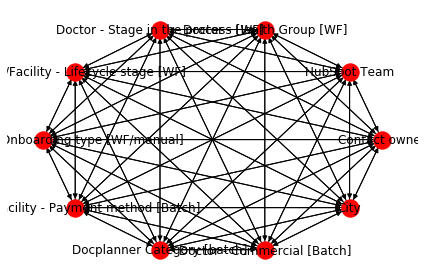

In [25]:
from causalnex.plots import plot_structure

fig, ax, nodes=plot_structure(sm)

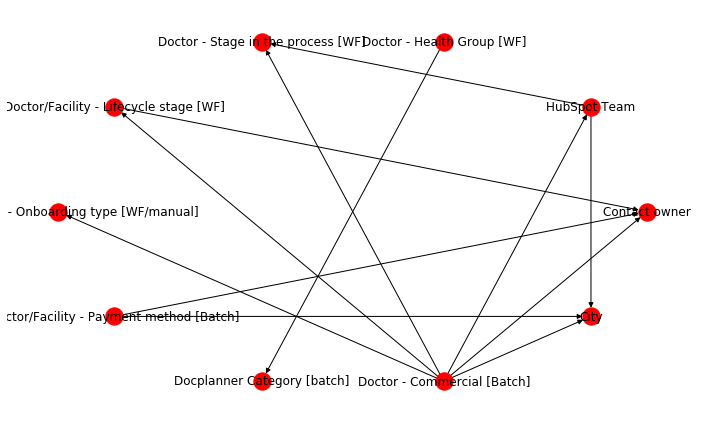

In [26]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
sm.remove_edges_below_threshold(.8)
fig , ax  , nodes = plot_structure(sm);

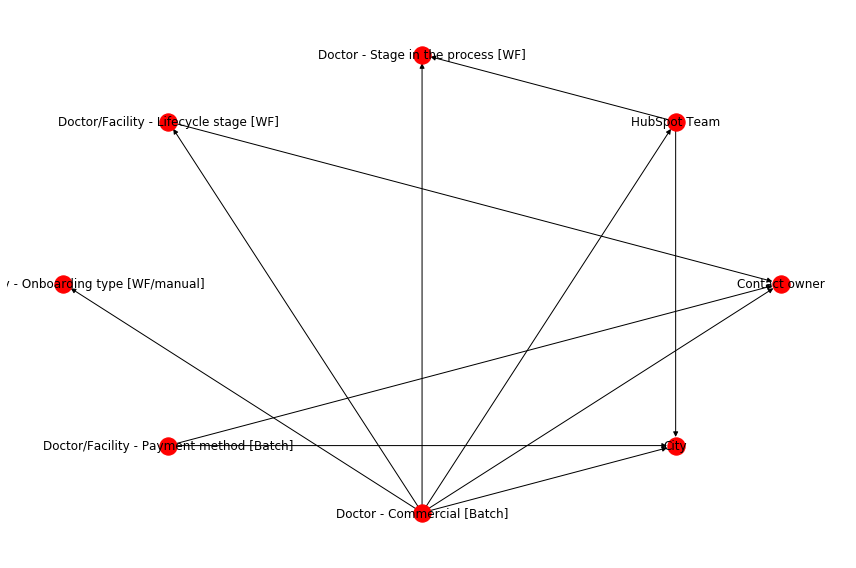

In [29]:
plt.rcParams['figure.figsize']=(12.0, 8.0)



sm=sm.get_largest_subgraph()

fig, ax, nodes=plot_structure(sm);


In [27]:
## Memory Optimization
for i in general1.select_dtypes('integer').columns:
    general1[i] = pd.to_numeric(general1[i], downcast = 'integer')
general1.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10156 entries, 0 to 10155
Data columns (total 10 columns):
Contact owner                                    10156 non-null int8
HubSpot Team                                     10156 non-null int8
Doctor - Health Group [WF]                       10156 non-null int8
Doctor - Stage in the process [WF]               10156 non-null int8
Doctor/Facility - Lifecycle stage [WF]           10156 non-null int8
Doctor/Facility - Onboarding type [WF/manual]    10156 non-null int8
Doctor/Facility - Payment method [Batch]         10156 non-null int8
Docplanner Category [batch]                      10156 non-null int8
Doctor - Commercial [Batch]                      10156 non-null int8
City                                             10156 non-null int8
dtypes: int8(10)
memory usage: 99.3 KB


In [30]:
bn = BayesianNetwork(sm)

In [31]:

bn = bn.fit_node_states(general1)

In [33]:
bn = bn.fit_cpds(general1, method = 'BayesianEstimator', bayes_prior = 'K2' )

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5069: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.

C:\Users\Data Analyst\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5070: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.



In [36]:
bn.cpds['Doctor - Commercial [Batch]']

,
Doctor - Commercial [Batch],
1,1.0
